In [1]:
import numpy as np
import math as math 
import pandas as pd
import matplotlib as plt
import seaborn as sns
from matplotlib import pyplot as plt
import datetime
import calendar
# from datetime import datetime

from astral.sun import sun
from astral import LocationInfo

import warnings

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder

from shapely.geometry.point import Point
import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely import wkt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import make_regression
from sklearn import metrics

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

### Read input files

In [2]:
df_all = pd.read_csv('/Volumes/CUNYGC/GC/CIS74020_ML/Final Project/Data/NYPD_Complaint_All_Clean.csv', sep=",")

subway = pd.read_csv('/Volumes/CUNYGC/GC/CIS74020_ML/Final Project/Data/SUBWAY_ENTRANCE.csv')

nynta = pd.read_csv ('/Volumes/CUNYGC/GC/CIS74020_ML/Final Project/Data/nynta.csv')

nyc_pop = pd.read_csv('/Volumes/CUNYGC/GC/CIS74020_ML/Final Project/Data/New_York_City_Population_By_Neighborhood_Tabulation_Areas.csv')
nyc_pop2010 = nyc_pop[nyc_pop['Year'] == 2010]

holidays = pd.read_csv ('/Volumes/CUNYGC/GC/CIS74020_ML/Final Project/Data/US_Holiday_Dates.csv')

### Plot crime classification LAW_CAT_CD

([<matplotlib.axis.XTick at 0x10aeed1c0>,
 [Text(0, 0, 'Monday'),
  Text(1, 0, 'Tuesday'),
  Text(2, 0, 'Wednesday'),
  Text(3, 0, 'Thrursday'),
  Text(4, 0, 'Friday'),
  Text(5, 0, 'Saturday'),
  Text(6, 0, 'Sunday')])

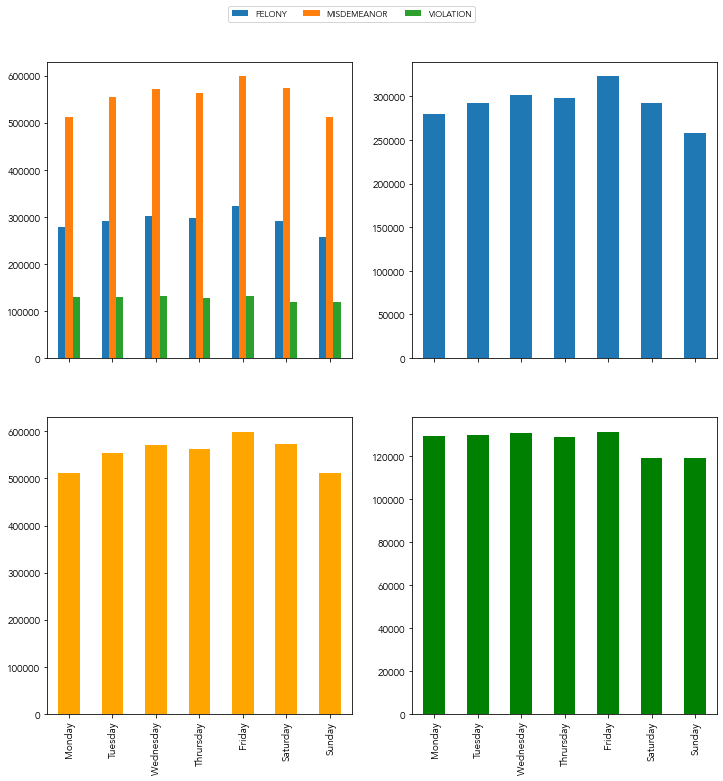

In [3]:
df_all_day = df_all.groupby(['LAW_CAT_CD','DAY_OF_WEEK']).size().reset_index(name='counts') #per day
df_all_day_pivot = df_all_day.pivot(index='DAY_OF_WEEK', columns='LAW_CAT_CD', values='counts').reset_index()

df_all_day_pivot['DAY_OF_WEEK'] = df_all_day_pivot['DAY_OF_WEEK'].apply(lambda x: calendar.day_name[x] )

# df_all_day_pivot.plot(kind='bar', x='DAY_OF_WEEK', stacked=False)

plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['font.family'] = "Avenir"
fig, ax = plt.subplots(2, 2, sharex=True)  #sharex="all", sharey="all"
ax[0,0] = df_all_day_pivot.plot(kind='bar',x='DAY_OF_WEEK', ax=ax[0,0]) #x='DAY_OF_WEEK'
ax[0,0].get_legend().remove()
ax[0,1] = df_all_day_pivot['FELONY'].plot(kind='bar', x='DAY_OF_WEEK', ax=ax[0,1])
ax[1,0] = df_all_day_pivot['MISDEMEANOR'].plot(kind='bar', x='DAY_OF_WEEK', ax=ax[1,0], color = 'orange')
ax[1,1] = df_all_day_pivot['VIOLATION'].plot(kind='bar', x='DAY_OF_WEEK', ax=ax[1,1], color = 'green')
ax[0,0].legend(loc='upper center', bbox_to_anchor=(1, 1.2), ncol=3, fontsize='small')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ["Monday", "Tuesday", "Wednesday", "Thrursday", "Friday", "Saturday", "Sunday"])

### Plot top 7 crimes type in each  crime classification 

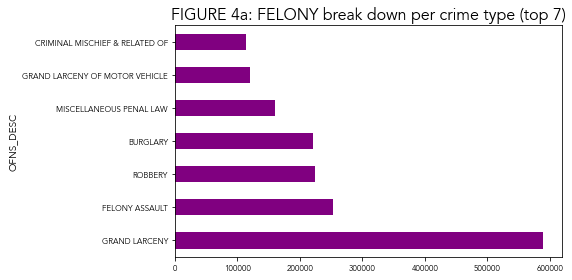

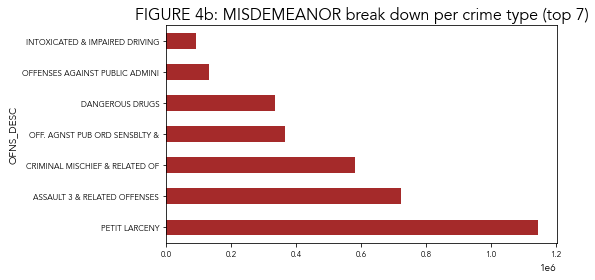

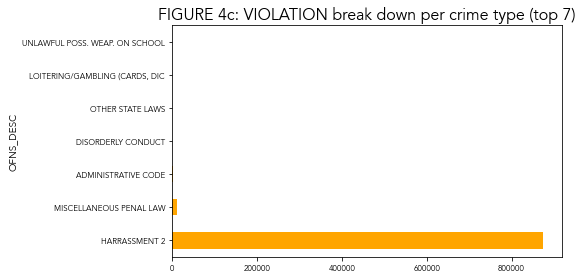

In [4]:
#%%
# LAW_CAT_CD (FELONY, MISDEMEANOR, VIOLATION) trends
feln_crimes_break =  df_all[df_all.LAW_CAT_CD == 'FELONY'].groupby(['OFNS_DESC']).size().sort_values(ascending=False).reset_index(name='counts').head(7)
misd_crimes_break =  df_all[df_all.LAW_CAT_CD == 'MISDEMEANOR'].groupby(['OFNS_DESC']).size().sort_values(ascending=False).reset_index(name='counts').head(7)
viol_crimes_break =  df_all[df_all.LAW_CAT_CD == 'VIOLATION'].groupby(['OFNS_DESC']).size().sort_values(ascending=False).reset_index(name='counts').head(7)

plt.rcParams['font.family'] = "Avenir"
feln_crimes_break.plot.barh(x='OFNS_DESC', y='counts',color = 'purple', figsize=[8,4], fontsize=8, legend=False) 
plt.title('FIGURE 4a: FELONY break down per crime type (top 7)', fontsize=16)
plt.tight_layout()

misd_crimes_break.plot.barh(x='OFNS_DESC', y='counts',color = 'brown', figsize=[8,4], fontsize=8, legend=False) 
plt.title('FIGURE 4b: MISDEMEANOR break down per crime type (top 7)', fontsize=16)
plt.tight_layout()

viol_crimes_break.plot.barh(x='OFNS_DESC', y='counts',color = 'orange', figsize=[8,4], fontsize=8, legend=False) 
plt.title('FIGURE 4c: VIOLATION break down per crime type (top 7)', fontsize=16)
plt.tight_layout()

### Plot top 7 crimes type regardless of crime classification 

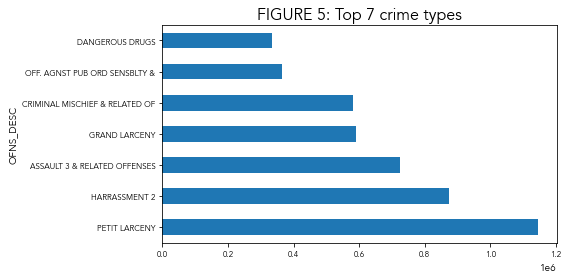

In [5]:
all_crimes_break =  df_all.groupby(['LAW_CAT_CD', 'OFNS_DESC']).size().sort_values(ascending=False).reset_index(name='counts').head(7)

all_crimes_break.plot.barh(x='OFNS_DESC', y='counts', figsize=[8,4], fontsize=8, legend=False )  #hue='OFNS_DESC'
plt.title('FIGURE 5: Top 7 crime types', fontsize=16)
plt.tight_layout()

### Plot larceny trends: for day of the week and for week of the year

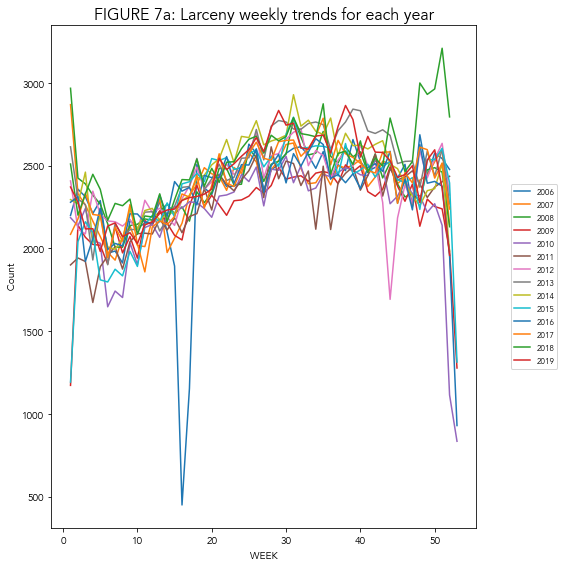

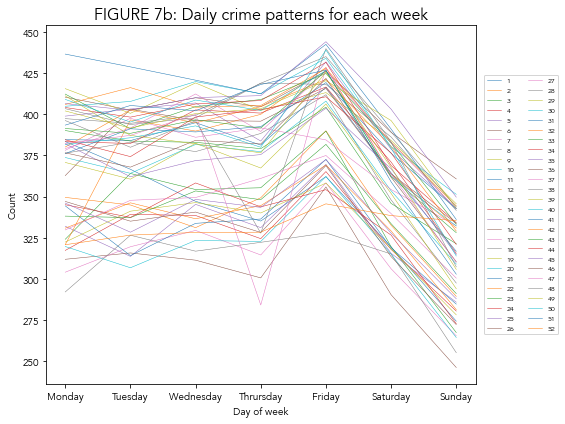

In [6]:
ofns_list = ['PETIT LARCENY', 'GRAND LARCENY']

df_all_sel = df_all[df_all['OFNS_DESC'].isin(ofns_list) ]

#Define grouping for aggregation
#++++++++++++++ Weeky total set up   +++++++++++++++++
df_count_w = df_all_sel.groupby(['NTACode', 'YEAR', 'WEEK']).size().reset_index(name='counts') #per day

#++++++++++++++ Daily average set up   +++++++++++++++++
#Define grouping for aggregation
df_count_d = df_all_sel.groupby(['NTACode', 'WEEK', 'DAY_OF_WEEK']).size().reset_index(name='counts') #per day
num_of_years = len(df_all_sel.YEAR.unique())
df_count_d.counts = df_count_d.counts/num_of_years


#--------------
df_count_w1 = df_all_sel.groupby(['YEAR', 'WEEK']).size().reset_index(name='counts') #per day

df_count_w1_pivot = df_count_w1.pivot(index='WEEK', columns='YEAR', values='counts').reset_index()

df_count_w1_pivot.plot(x='WEEK',figsize=[8,8], xlabel = 'WEEK', ylabel = ' Count') 
plt.title('FIGURE 7a: Larceny weekly trends for each year', fontsize=16)
plt.legend(loc='right', bbox_to_anchor=(1.2, .5), ncol=1, fontsize=8)
plt.tight_layout()

#-----------
 

df_count_d1 = df_all_sel.groupby(['WEEK', 'DAY_OF_WEEK']).size().reset_index(name='counts') #per day
df_count_d1['counts'] = df_count_d1['counts']/13

df_count_d1_pivot = df_count_d1[df_count_d1.WEEK < 53].pivot(index='DAY_OF_WEEK', columns='WEEK', values='counts').reset_index()


df_count_d1_pivot.plot(x='DAY_OF_WEEK',figsize=[8,6], xlabel = 'Day of week', ylabel = 'Count', linestyle='-', lw=.5) 
plt.xticks([0, 1, 2, 3, 4, 5, 6], ["Monday", "Tuesday", "Wednesday", "Thrursday", "Friday", "Saturday", "Sunday"])
plt.title('FIGURE 7b: Daily crime patterns for each week', fontsize=16)
plt.legend(loc='center right', bbox_to_anchor=(1.2, .5), ncol=2, fontsize=7)
plt.tight_layout()

### Plot trends of the top crimes

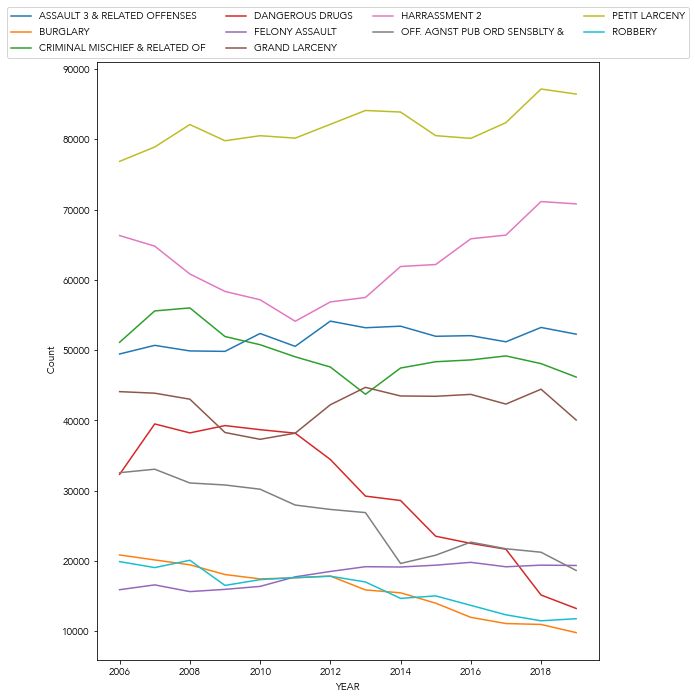

In [7]:
df_all_cat_year_ofs = df_all.groupby(['OFNS_DESC']).size().reset_index(name='counts') #per day

#Selet top 10 OFNS_DESC
top_ofs = df_all.groupby(['OFNS_DESC']).size().sort_values(ascending=False).head(10).reset_index()['OFNS_DESC']
top_ofs_list = list(top_ofs)
df_all_top_ofs = df_all[df_all['OFNS_DESC'].isin(top_ofs_list) ]


df_all_top_ofs = df_all_top_ofs.groupby(['OFNS_DESC', 'YEAR']).size().reset_index(name='counts') #per day
df_all_top_ofs_pivot = df_all_top_ofs.pivot(index='YEAR', columns='OFNS_DESC', values='counts').reset_index()

df_all_top_ofs_pivot.plot(x='YEAR',figsize=[9,11], xlabel = 'YEAR', ylabel = ' Count') 
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4, fontsize=10)

### Plot cirme classification trend and distribution

Text(0.5, 1.0, 'Crime category time series')

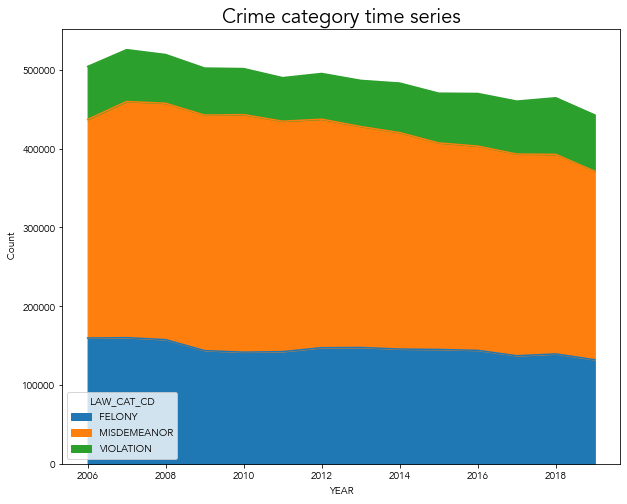

In [8]:
df_all_cat_year = df_all.groupby(['LAW_CAT_CD', 'YEAR']).size().reset_index(name='counts') #per day
df_all_cat_year_pivot = df_all_cat_year.pivot(index='YEAR', columns='LAW_CAT_CD', values='counts').reset_index()

df_all_cat_year_pivot.plot(kind='area',x='YEAR',figsize=[10,8], xlabel = 'YEAR', ylabel = ' Count')
plt.title('Crime category time series', fontsize=20)

### Plot day of the week trends for 16 crime types

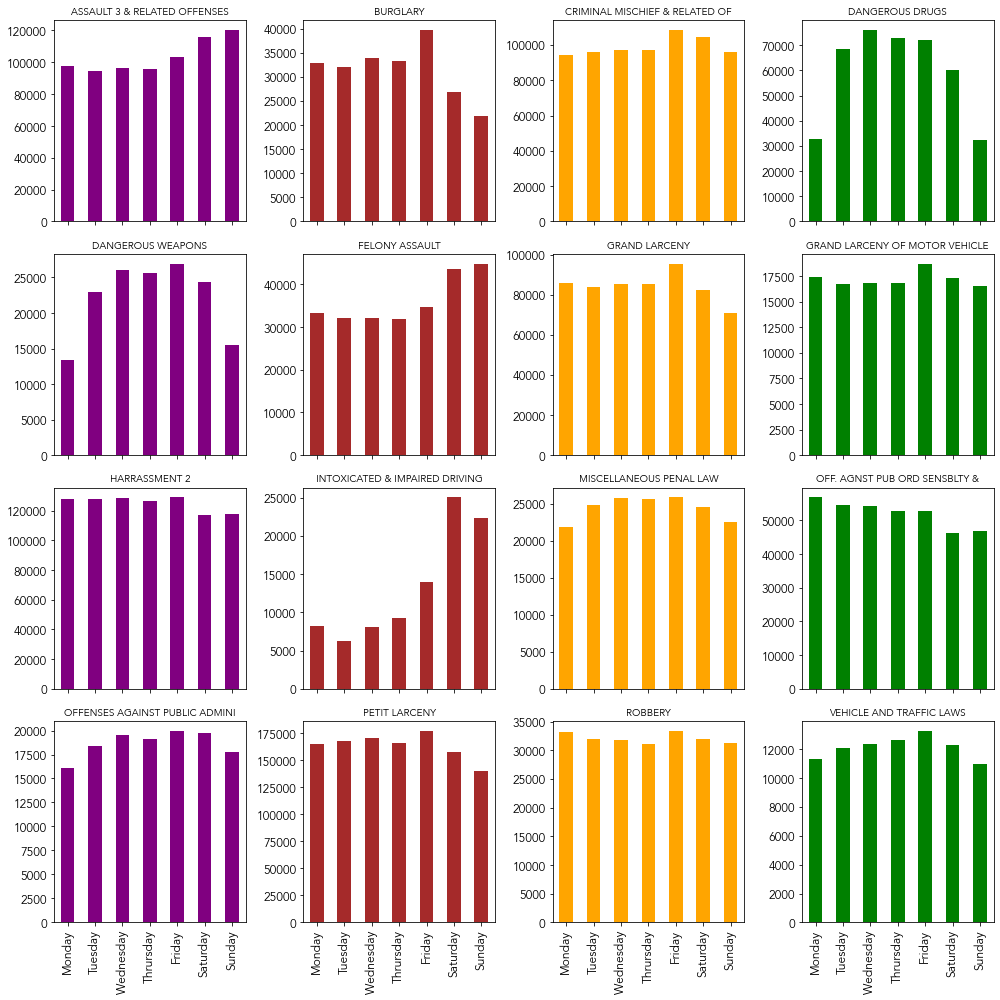

In [9]:
top_ofs = df_all.groupby(['OFNS_DESC']).size().sort_values(ascending=False).head(16).reset_index()['OFNS_DESC']
top_ofs_list = list(top_ofs)
df_all_top_ofs = df_all[df_all['OFNS_DESC'].isin(top_ofs_list) ]

df_all_day = df_all_top_ofs.groupby(['OFNS_DESC','DAY_OF_WEEK']).size().reset_index(name='counts') #per day
df_all_day_pivot = df_all_day.pivot(index='DAY_OF_WEEK', columns='OFNS_DESC', values='counts').reset_index()

df_all_day_pivot['DAY_OF_WEEK'] = df_all_day_pivot['DAY_OF_WEEK'].apply(lambda x: calendar.day_name[x] )

# df_all_day_pivot.plot(kind='bar', x='DAY_OF_WEEK', stacked=False)

plt.rcParams['figure.figsize'] = (14, 14)
plt.rcParams['font.family'] = "Avenir"
fig, ax = plt.subplots(4, 4, sharex=True)  #sharex="all", sharey="all"  
# plt.set_title(size=10) # Title 

ax[0,0] = df_all_day_pivot.iloc[:,1].plot(kind='bar', ax=ax[0,0],color = 'purple', fontsize=12), ax[0,0].set_title (df_all_day_pivot.columns[1], fontsize=10)
ax[0,1] = df_all_day_pivot.iloc[:,2].plot(kind='bar', ax=ax[0,1], color = 'brown', fontsize=12),  ax[0,1].set_title (df_all_day_pivot.columns[2], fontsize=10)
ax[0,2] = df_all_day_pivot.iloc[:,3].plot(kind='bar', ax=ax[0,2], color = 'orange', fontsize=12), ax[0,2].set_title (df_all_day_pivot.columns[3], fontsize=10)
ax[0,3] = df_all_day_pivot.iloc[:,4].plot(kind='bar', ax=ax[0,3], color = 'green', fontsize=12), ax[0,3].set_title (df_all_day_pivot.columns[4], fontsize=10)
ax[1,0] = df_all_day_pivot.iloc[:,5].plot(kind='bar', ax=ax[1,0],color = 'purple', fontsize=12),ax[1,0].set_title (df_all_day_pivot.columns[5], fontsize=10) 
ax[1,1] = df_all_day_pivot.iloc[:,6].plot(kind='bar', ax=ax[1,1], color = 'brown',  fontsize=12),ax[1,1].set_title (df_all_day_pivot.columns[6], fontsize=10) 
ax[1,2] = df_all_day_pivot.iloc[:,7].plot(kind='bar', ax=ax[1,2], color = 'orange',fontsize=12),ax[1,2].set_title (df_all_day_pivot.columns[7], fontsize=10) 
ax[1,3] = df_all_day_pivot.iloc[:,8].plot(kind='bar', ax=ax[1,3], color = 'green', fontsize=12),ax[1,3].set_title (df_all_day_pivot.columns[8], fontsize=10) 
ax[2,0] = df_all_day_pivot.iloc[:,9].plot(kind='bar', ax=ax[2,0],color = 'purple', fontsize=12),ax[2,0].set_title (df_all_day_pivot.columns[9], fontsize=10) 
ax[2,1] = df_all_day_pivot.iloc[:,10].plot(kind='bar', ax=ax[2,1], color = 'brown', fontsize=12),ax[2,1].set_title (df_all_day_pivot.columns[10], fontsize=10) 
ax[2,2] = df_all_day_pivot.iloc[:,11].plot(kind='bar', ax=ax[2,2], color = 'orange',fontsize=12),ax[2,2].set_title (df_all_day_pivot.columns[11], fontsize=10) 
ax[2,3] = df_all_day_pivot.iloc[:,12].plot(kind='bar', ax=ax[2,3], color = 'green', fontsize=12),ax[2,3].set_title (df_all_day_pivot.columns[12], fontsize=10) 
ax[3,0] = df_all_day_pivot.iloc[:,13].plot(kind='bar', ax=ax[3,0],color = 'purple', fontsize=12),ax[3,0].set_title (df_all_day_pivot.columns[13], fontsize=10)  
ax[3,1] = df_all_day_pivot.iloc[:,14].plot(kind='bar', ax=ax[3,1], color = 'brown', fontsize=12),ax[3,1].set_title (df_all_day_pivot.columns[14], fontsize=10) 
ax[3,2] = df_all_day_pivot.iloc[:,15].plot(kind='bar', ax=ax[3,2], color = 'orange',fontsize=12),ax[3,2].set_title (df_all_day_pivot.columns[15], fontsize=10) 
ax[3,3] = df_all_day_pivot.iloc[:,16].plot(kind='bar', ax=ax[3,3], color = 'green', fontsize=12),ax[3,3].set_title (df_all_day_pivot.columns[16], fontsize=10) 

plt.xticks([0, 1, 2, 3, 4, 5, 6], ["Monday", "Tuesday", "Wednesday", "Thrursday", "Friday", "Saturday", "Sunday"])
plt.tight_layout()

### Plot weekly trends for crime classification

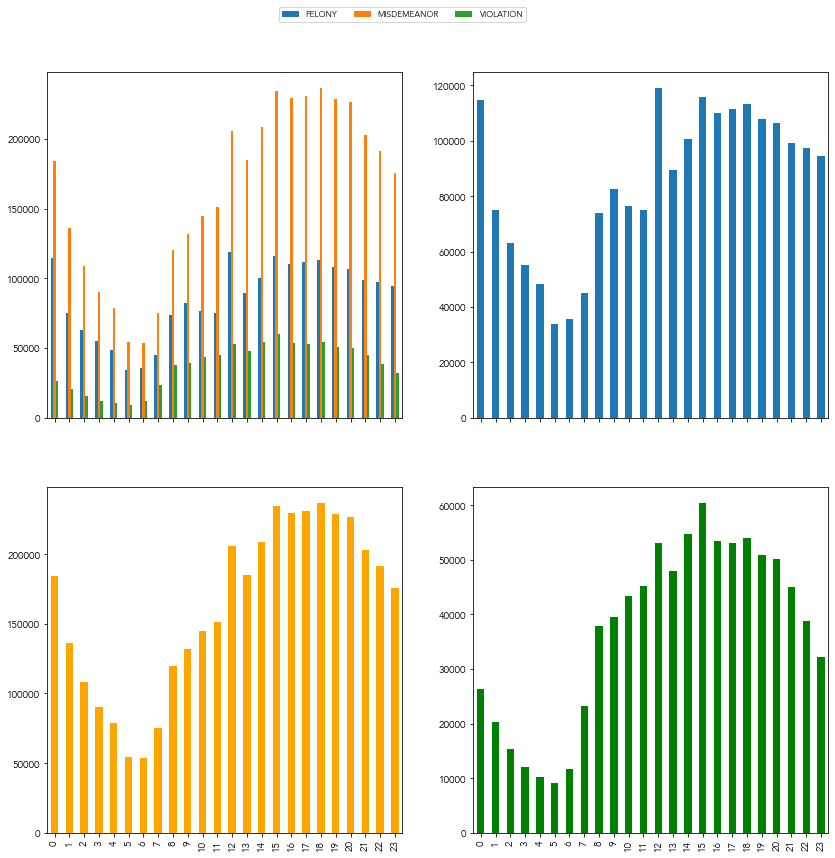

In [10]:
df_all_day = df_all.groupby(['LAW_CAT_CD','TIME']).size().reset_index(name='counts') #per day
df_all_day_pivot = df_all_day.pivot(index='TIME', columns='LAW_CAT_CD', values='counts').reset_index()

# df_all_day_pivot.plot(kind='bar', x='DAY_OF_WEEK', stacked=False)

plt.rcParams['figure.figsize'] = (14, 14)
plt.rcParams['font.family'] = "Avenir"
fig, ax = plt.subplots(2, 2, sharex=True)  #sharex="all", sharey="all"
ax[0,0] = df_all_day_pivot.plot(kind='bar',x='TIME', ax=ax[0,0]) #x='DAY_OF_WEEK'
ax[0,0].get_legend().remove()
ax[0,1] = df_all_day_pivot['FELONY'].plot(kind='bar', x='TIME', ax=ax[0,1])
ax[1,0] = df_all_day_pivot['MISDEMEANOR'].plot(kind='bar', x='TIME', ax=ax[1,0], color = 'orange')
ax[1,1] = df_all_day_pivot['VIOLATION'].plot(kind='bar', x='TIME', ax=ax[1,1], color = 'green')
ax[0,0].legend(loc='upper center', bbox_to_anchor=(1, 1.2), ncol=3, fontsize='small')

### Plot top 16 crime type hour of day trends

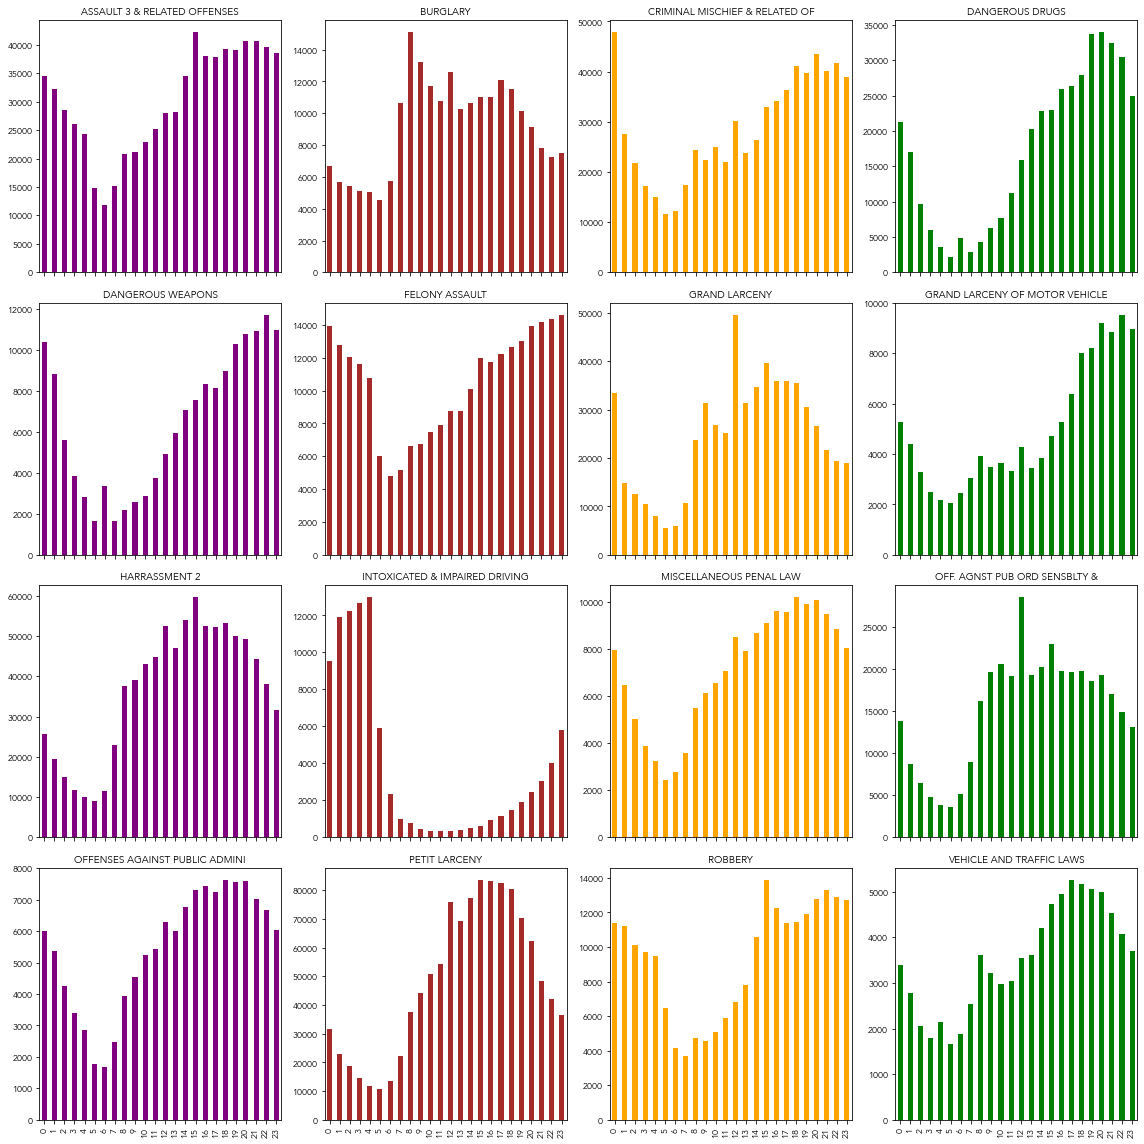

In [11]:
top_ofs = df_all.groupby(['OFNS_DESC']).size().sort_values(ascending=False).head(16).reset_index()['OFNS_DESC']
top_ofs_list = list(top_ofs)
df_all_top_ofs = df_all[df_all['OFNS_DESC'].isin(top_ofs_list) ]


df_all_day = df_all_top_ofs.groupby(['OFNS_DESC','TIME']).size().reset_index(name='counts') #per day
df_all_day_pivot = df_all_day.pivot(index='TIME', columns='OFNS_DESC', values='counts').reset_index()

plt.rcParams['figure.figsize'] = (16, 16)
plt.rcParams['font.family'] = "Avenir"
fig, ax = plt.subplots(4, 4, sharex=True)  #sharex="all", sharey="all"  

ax[0,0] = df_all_day_pivot.iloc[:,1].plot(kind='bar', ax=ax[0,0],color = 'purple', fontsize=9), ax[0,0].set_title (df_all_day_pivot.columns[1], fontsize=10)
ax[0,1] = df_all_day_pivot.iloc[:,2].plot(kind='bar', ax=ax[0,1], color = 'brown', fontsize=9),  ax[0,1].set_title (df_all_day_pivot.columns[2], fontsize=10)
ax[0,2] = df_all_day_pivot.iloc[:,3].plot(kind='bar', ax=ax[0,2], color = 'orange', fontsize=9), ax[0,2].set_title (df_all_day_pivot.columns[3], fontsize=10)
ax[0,3] = df_all_day_pivot.iloc[:,4].plot(kind='bar', ax=ax[0,3], color = 'green', fontsize=9), ax[0,3].set_title (df_all_day_pivot.columns[4], fontsize=10)
ax[1,0] = df_all_day_pivot.iloc[:,5].plot(kind='bar', ax=ax[1,0],color = 'purple', fontsize=9),ax[1,0].set_title (df_all_day_pivot.columns[5], fontsize=10) 
ax[1,1] = df_all_day_pivot.iloc[:,6].plot(kind='bar', ax=ax[1,1], color = 'brown',  fontsize=9),ax[1,1].set_title (df_all_day_pivot.columns[6], fontsize=10) 
ax[1,2] = df_all_day_pivot.iloc[:,7].plot(kind='bar', ax=ax[1,2], color = 'orange',fontsize=9),ax[1,2].set_title (df_all_day_pivot.columns[7], fontsize=10) 
ax[1,3] = df_all_day_pivot.iloc[:,8].plot(kind='bar', ax=ax[1,3], color = 'green', fontsize=9),ax[1,3].set_title (df_all_day_pivot.columns[8], fontsize=10) 
ax[2,0] = df_all_day_pivot.iloc[:,9].plot(kind='bar', ax=ax[2,0],color = 'purple', fontsize=9),ax[2,0].set_title (df_all_day_pivot.columns[9], fontsize=10) 
ax[2,1] = df_all_day_pivot.iloc[:,10].plot(kind='bar', ax=ax[2,1], color = 'brown', fontsize=9),ax[2,1].set_title (df_all_day_pivot.columns[10], fontsize=10) 
ax[2,2] = df_all_day_pivot.iloc[:,11].plot(kind='bar', ax=ax[2,2], color = 'orange',fontsize=9),ax[2,2].set_title (df_all_day_pivot.columns[11], fontsize=10) 
ax[2,3] = df_all_day_pivot.iloc[:,12].plot(kind='bar', ax=ax[2,3], color = 'green', fontsize=9),ax[2,3].set_title (df_all_day_pivot.columns[12], fontsize=10) 
ax[3,0] = df_all_day_pivot.iloc[:,13].plot(kind='bar', ax=ax[3,0],color = 'purple', fontsize=9),ax[3,0].set_title (df_all_day_pivot.columns[13], fontsize=10)  
ax[3,1] = df_all_day_pivot.iloc[:,14].plot(kind='bar', ax=ax[3,1], color = 'brown', fontsize=9),ax[3,1].set_title (df_all_day_pivot.columns[14], fontsize=10) 
ax[3,2] = df_all_day_pivot.iloc[:,15].plot(kind='bar', ax=ax[3,2], color = 'orange',fontsize=9),ax[3,2].set_title (df_all_day_pivot.columns[15], fontsize=10) 
ax[3,3] = df_all_day_pivot.iloc[:,16].plot(kind='bar', ax=ax[3,3], color = 'green', fontsize=9),ax[3,3].set_title (df_all_day_pivot.columns[16], fontsize=10) 

plt.tight_layout()